1. Loading the dataset

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# 1.3. Load the training, validation and test datasets into a dataframes 
# Load the Parquet files into DataFrames
X_train = pd.read_parquet('../data/processed/X_train_resampled.parquet')
X_val = pd.read_parquet('../data/processed/X_val.parquet')
y_train = pd.read_parquet('../data/processed/y_train_resampled.parquet')
y_val = pd.read_parquet('../data/processed/y_val.parquet')
X_test = pd.read_parquet('../data/processed/test_cleaned.parquet')

In [4]:
# taking out the player id out of the test data
player_id_test = X_test.pop('player_id')

In [5]:
y_val = y_val.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_val.shape

(9324,)

In [6]:
y_train = y_train.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_train.shape

(37294,)

3. Support Vector Machines - Modelling

In [7]:
#3.1 Import SVM and instantiate the model
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Initialize the SVM model
svc1 = SVC(kernel='linear', probability=True)  

# Initialize RFE with the SVM model - Recursive Feature Elimination (RFE) to systematically select the most important features.
rfe = RFE(estimator=svc1, n_features_to_select=10)  # Select top 10 features

# Create a pipeline with RFE and SVM
pipeline = Pipeline([
    ('feature_selection', rfe),
    ('classification', svc1)
])


In [8]:
# 3.2 Train the model and save the predicted values
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 RFE(estimator=SVC(kernel='linear', probability=True),
                     n_features_to_select=10)),
                ('classification', SVC(kernel='linear', probability=True))])

In [9]:
# Select the probability for the positive class (class 1)
y_train_probs_svc1 = pipeline.predict_proba(X_train)[:, 1]
y_val_probs_svc1 = pipeline.predict_proba(X_val)[:, 1]

In [11]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report
# Predict class labels
y_val_pred = pipeline.predict(X_val)

# Print classification report
print(classification_report(y_val, y_val_pred))

# Print selected features
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9222
         1.0       0.00      0.00      0.00       102

    accuracy                           0.99      9324
   macro avg       0.49      0.50      0.50      9324
weighted avg       0.98      0.99      0.98      9324

Selected features: Index(['conf_AE', 'conf_BSky', 'conf_MVC', 'conf_P12', 'conf_SB', 'FTM', 'FTA',
       'porpag', 'dporpag', 'mp'],
      dtype='object')


C:\Users\paiyn\AppData\Local\pypoetry\Cache\virtualenvs\kaggle1-nbadraft-risGQE3a-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\paiyn\AppData\Local\pypoetry\Cache\virtualenvs\kaggle1-nbadraft-risGQE3a-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\paiyn\AppData\Local\pypoetry\Cache\virtualenvs\kaggle1-nbadraft-risGQE3a-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

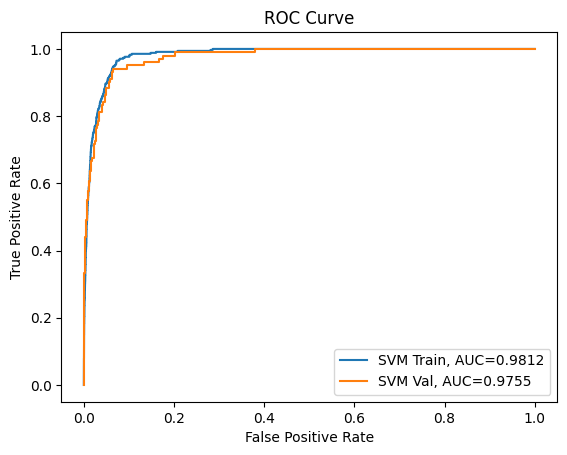

In [12]:
# 3.3 To plot ROC curve and the AUC metric - for comparison of model performances
#To plot ROC curve and the AUC metric

# Set up plotting area
plt.figure(0).clf()

# SVM - Train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs_svc1)
auc = round(metrics.roc_auc_score(y_train, y_train_probs_svc1), 4)
plt.plot(fpr, tpr, label="SVM Train, AUC="+str(auc))

# SVM - Validation
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs_svc1)
auc = round(metrics.roc_auc_score(y_val, y_val_probs_svc1), 4)
plt.plot(fpr, tpr, label="SVM Val, AUC="+str(auc))

# Add legend
plt.legend()

# Show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [13]:
# 3.4 Save the probability of the test data
y_test_probs_svc1 = pipeline.predict_proba(X_test)[:, 1]


In [14]:
# 3.5 add the 'player_id'column  into the prediction probability
# Convert y_test_prob_rf3 (which is a NumPy array) to a DataFrame
y_test_probs_df = pd.DataFrame(y_test_probs_svc1, columns=['drafted'])

# Concatenate player_id_test and y_test_prob_df along the columns
Results_1 = pd.concat([player_id_test, y_test_probs_df], axis=1)

In [15]:
Results_1

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,3.686828e-06
1,52a518bb-b34a-4b43-adee-5e996cb853fa,2.311009e-07
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,1.000000e-07
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,2.286075e-06
4,55d07491-5bd1-447f-844e-9cb36eaa442e,3.759245e-04
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,3.182166e-07
4966,c32a466d-7a66-47eb-805c-a94e328261bc,1.403468e-07
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,6.098310e-06
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,1.160492e-05


In [16]:
#3.6 save the probability as CSV file

# Convert to DataFrame and save
pd.DataFrame(Results_1).to_csv('../data/external/smote_SVM_Results.csv', index=False)
pd.DataFrame(selected_features).to_csv('../data/processed/SVM_selected_features.csv', index=False)


#3.7 save the model
# Import dump from joblib
from joblib import dump

# 3.12 Save the model and call the files respectively SVM.joblib 
dump(svc1, '../models/SVM_RFE_smote.joblib')


['../models/SVM_RFE_smote.joblib']